In [26]:
# import numpy as np
# import pandas as pd
# import openml


# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score


# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# import seaborn as sns

# from venn_abers import VennAbersCalibrator, VennAbers

# from crepes import WrapClassifier, ConformalClassifier

# from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
# from nonconformist.cp import TcpClassifier


# import warnings
# warnings.filterwarnings('ignore')




# # from collections import Counter


In [30]:
import sys
import numpy as np
import pandas as pd

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
from xgboost import XGBClassifier


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import (regression_coverage_score,
                           coverage_width_based,
                           regression_mean_width_score,)
from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


# German Credit Dataset

In [6]:
# dataset

dataset_id = 31 # German Credit Data
dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# handle datatypes
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['category']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert uint8 to int
uint8_columns = X.select_dtypes(include=['uint8']).columns
for column in uint8_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


# standardize the data
scaler = StandardScaler()
X[uint8_columns] = scaler.fit_transform(X[uint8_columns])
X[['credit_amount']] = scaler.fit_transform(X[['credit_amount']])

# display dataset
display(X.head(5))
print("class labels:", label_encoder.classes_)
print("class distribution:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,-1.236478,1,6,-0.745131,4,3,0.918477,3,2,1.046987,3,2.766456,1,1,1.027079,1,-0.428290,1,1
1,0,2.248194,3,6,0.949817,2,0,-0.870183,0,2,-0.765977,3,-1.191404,1,1,-0.704926,1,-0.428290,0,1
2,3,-0.738668,1,2,-0.416562,2,1,-0.870183,3,2,0.140505,3,1.183312,1,1,-0.704926,3,2.334869,0,1
3,1,1.750384,3,3,1.634247,2,1,-0.870183,3,1,1.046987,1,0.831502,1,0,-0.704926,1,2.334869,0,1
4,1,0.256953,2,4,0.566664,2,0,0.024147,3,2,1.046987,2,1.535122,1,0,1.027079,1,2.334869,0,1


class labels: ['bad' 'good']
class distribution: [300 700]


## Model Training and Evaluation

In [7]:
# base model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

##### Nonconformist Library

Coverage: 0.880
Average Set Width: 1.22


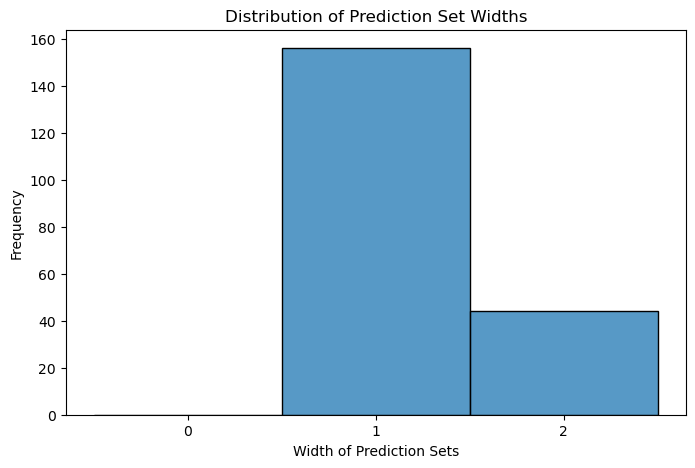

In [8]:
# using Transductive Conformal Prediction
nc = NcFactory.create_nc(clf, err_func=InverseProbabilityErrFunc())
tcp = TcpClassifier(nc)

tcp.fit(X_train, y_train)

predictions = tcp.predict(X_test.values, significance=0.1)

# evaluation
coverage = np.mean([predictions[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in predictions]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.3f}")
print(f"Average Set Width: {average_width:.2f}")
print(classification_report(y_test, [np.argmax(pred) for pred in predictions]))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Crepes Library

Coverage: 0.90
Average Set Width: 1.31


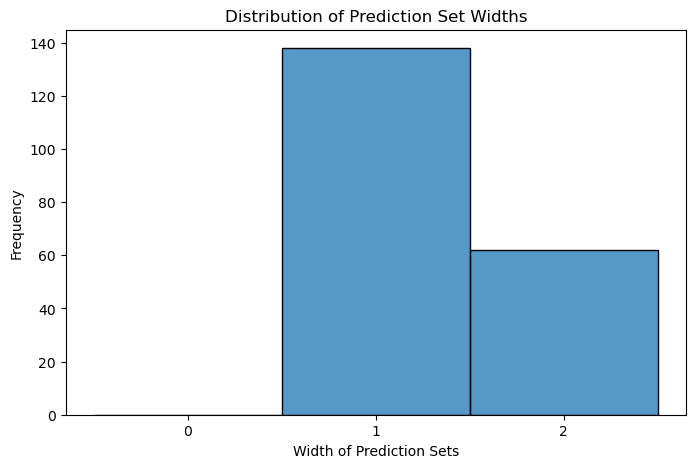

In [28]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.fit(X_train_proper, y_train_proper)
wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediction_sets)
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

Coverage: 0.90
Average Set Width: 1.31


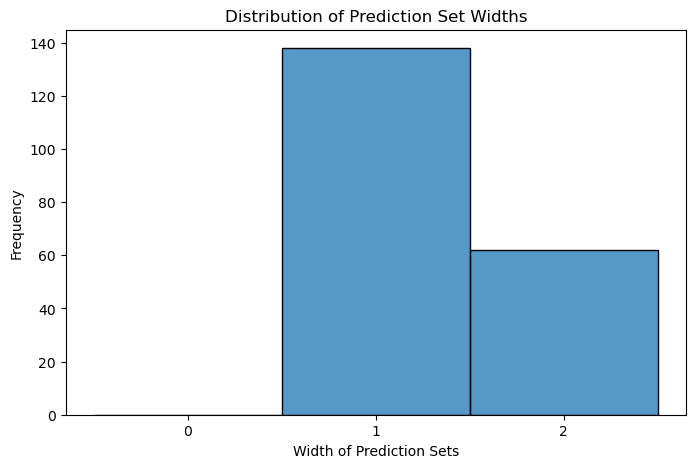

In [29]:
# Mondrian conformal classifiers Class-conditional
wrapped_clf = WrapClassifier(clf)
wrapped_clf.fit(X_train_proper, y_train_proper)

rf_class_cond = WrapClassifier(wrapped_clf.learner)
wrapped_clf = rf_class_cond
wrapped_clf.calibrate(X_cal, y_cal, class_cond=True)

prediciton_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediciton_sets[:5])
# print(prediciton_sets.shape)

# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Venn Abers Library

Accuracy: 0.76
##  Predictor: Inductive Venn-ABERS
####  ROC AUC 0.80845


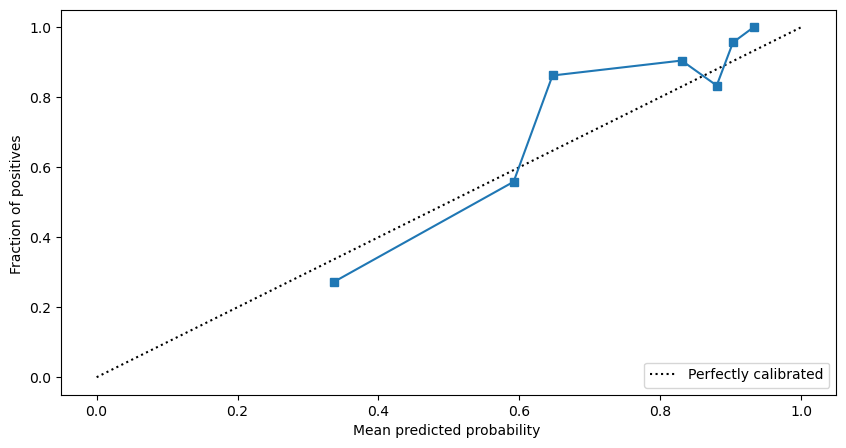

In [31]:
# model
# clf = XGBClassifier(random_state=42)

va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.2, shuffle=False)
va.fit(X_train, y_train)
va_inductive_prob = va.predict_proba(X_test)
va_inductive_pred = va.predict(X_test)
predictions = va_inductive_pred
prediction_prob = va_inductive_prob

# print(predictions[:5])
# print(y_test[:5])
# print(prediction_prob[:5])
# print(prediction_prob.shape)

# evaluation
predictions = np.argmax(va_inductive_prob, axis=1)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")

# plot prediction probabilities
predictions = [prediction_prob[:, 1],
              ]

prediction_names = ["Inductive Venn-ABERS",
              ]

for name, y_prob in enumerate(predictions):
    print('##  Predictor: ' + prediction_names[name] )
    # display(Markdown('####  Brier score ' + round(brier_score_loss(y_test, y_prob),5).astype("str") ))
    # display(Markdown('####  Log loss ' + round(log_loss(y_test, y_prob),5).astype("str") ))
    print('####  ROC AUC ' + round(roc_auc_score(y_test, y_prob),5).astype("str") )


    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()


Accuracy: 0.75
##  Predictor: Cross Venn-ABERS
####  ROC AUC 0.79192


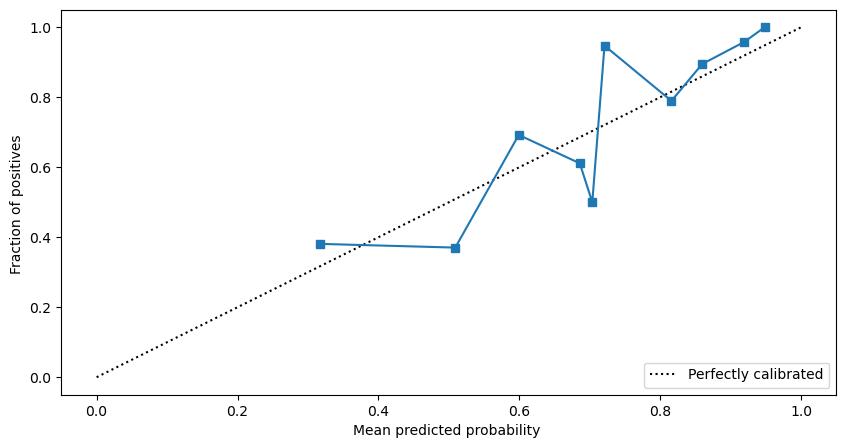

In [32]:
# model
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
va = VennAbersCalibrator(estimator=clf, inductive=False, n_splits=5, precision=4)
va.fit(X_train, y_train)
va_cross_prob = va.predict_proba(X_test)
va_cross_pred = va.predict(X_test)
predictions = va_cross_pred
prediction_prob = va_cross_prob

# print(predictions[:5])
# print(y_test[:5])
# print(prediction_prob[:5])
# print(prediction_prob.shape)

# evaluation
predictions = np.argmax(va_cross_prob, axis=1)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")

# plot prediction probabilities
predictions = [prediction_prob[:, 1],
              ]

prediction_names = ["Cross Venn-ABERS",
              ]

for name, y_prob in enumerate(predictions):
    print('##  Predictor: ' + prediction_names[name] )
    # display(Markdown('####  Brier score ' + round(brier_score_loss(y_test, y_prob),5).astype("str") ))
    # display(Markdown('####  Log loss ' + round(log_loss(y_test, y_prob),5).astype("str") ))
    print('####  ROC AUC ' + round(roc_auc_score(y_test, y_prob),5).astype("str") )


    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()


              precision    recall  f1-score   support

           0       0.67      0.54      0.60        59
           1       0.82      0.89      0.85       141

    accuracy                           0.79       200
   macro avg       0.74      0.71      0.73       200
weighted avg       0.78      0.79      0.78       200



,p0,p1,p,y
0,0.666667,1.000000,0.750000,0
1,-0.000000,1.000000,0.500000,1
2,-0.000000,0.032258,0.031250,1
3,-0.000000,1.000000,0.500000,1
4,0.989474,1.000000,0.989583,1
5,-0.000000,1.000000,0.500000,1
6,0.971429,1.000000,0.972222,1
7,-0.000000,1.000000,0.500000,1
8,0.985075,1.000000,0.985294,1
9,0.988889,1.000000,0.989011,1


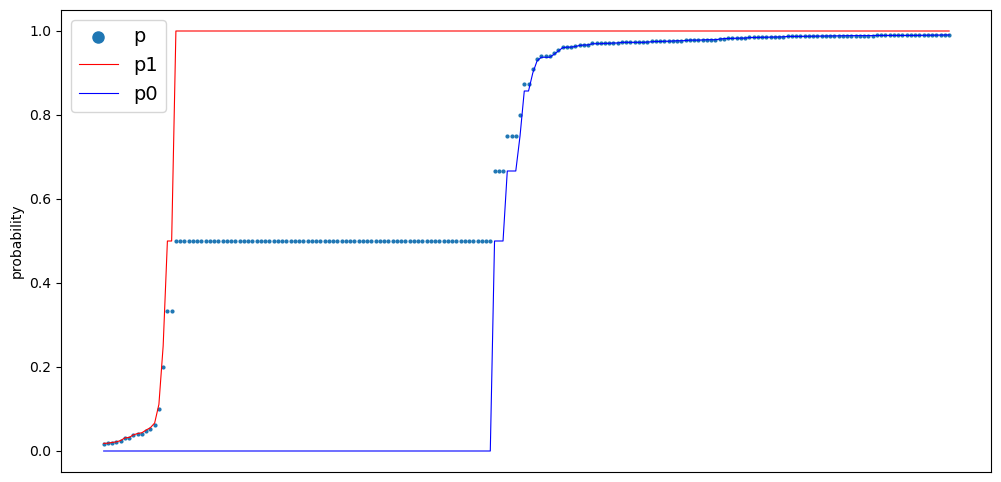

In [38]:
sys.path.append("VennABERS")
import VennABERS

clf.fit(X_train, y_train)
prediction_cls = clf.predict(X_test)

y_pred_calib = clf.predict_proba(X_cal)[:,1]
calibrPts = zip(list(y_pred_calib),list(y_cal))

testScores = clf.predict_proba(X_test)[:,1]
p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,testScores)
p = p1/(1-p0+p1)

print(classification_report(y_test, prediction_cls))

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': p0, 'p1': p1, 'p': p, 'y': y_test})
display(df.head(10))

predictions = pd.DataFrame(y_test)
predictions.columns = ['y_true']
predictions["p0"] = p0
predictions["p1"] = p1
predictions["p"]  = p
predictions["width"] = predictions["p1"] - predictions["p0"]
predictions = predictions.sort_values(by=['p'])
predictions = predictions.reset_index()

# # plot
# fig, ax = plt.subplots(figsize=(12, 6))
# plt.scatter(x=predictions.index,y=predictions["p1"],label="p1",s=4)
# plt.scatter(x=predictions.index,y=predictions["p0"],label="p0",s=4)
# plt.plot(predictions.index,predictions["width"],label="p1-p0",lw=0.8,color="green")
# plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
# plt.ylabel("probability")
# plt.xticks([])
# plt.show()

# plot predction probabilities for class 1 with intervals
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["p"],label="p",s=4)
plt.plot(predictions.index,predictions["p1"],label="p1",lw=0.8,color="red")
plt.plot(predictions.index,predictions["p0"],label="p0",lw=0.8,color="blue")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])
plt.show()

